In [46]:
from all_functions import *
import pandas as pd
from aeon.visualisation import plot_series

window = 12
horizon = 12
derivado = "gasolinac"
estado = "SP"
df = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(df, horizon)
train_tf = transform_train(train, format="normal")

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Mês', ylabel='Volume de Vendas (m³)'>)

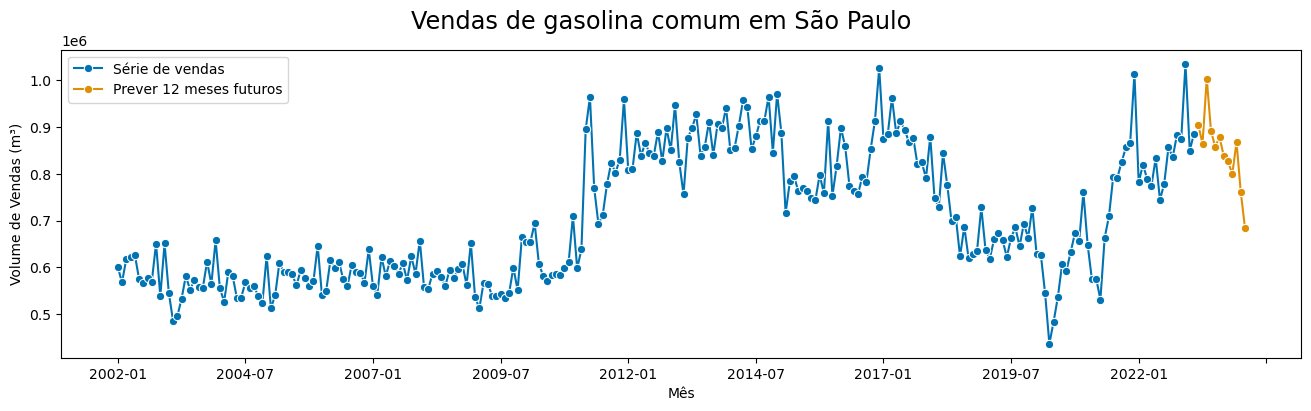

In [47]:
plot_series(train[36*4:], test, labels=["Série de vendas", "Prever 12 meses futuros"], title="Vendas de gasolina comum em São Paulo", y_label='Volume de Vendas (m³)', x_label="Mês")

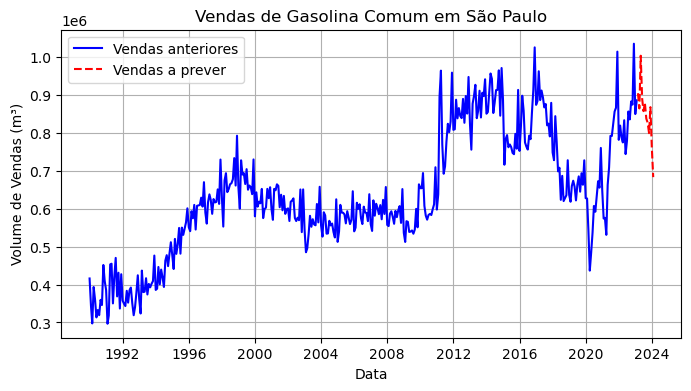

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()
# Plotar a série de treinamento
plt.plot(train.index, train.values, label='Vendas anteriores', color='blue')


# Plotar a previsão
plt.plot(test.index, test.values, label='Vendas a prever', color='red', linestyle='--')

# Adicionar legendas e rótulos
plt.title('Vendas de Gasolina Comum em São Paulo')
plt.xlabel('Data')
plt.ylabel('Volume de Vendas (m³)')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()